In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sn; sn.set(font_scale = 1.4)

import tensorflow as tf                
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import os
import cv2

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set the GPU as the device for operations
with tf.device('/GPU:0'):
    # Your model training or inference code here
    print("TensorFlow is using GPU.")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


In [3]:
EPOCHS = 100
BS = 64
DROPOUT_RATE = 0.25
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

tf.get_logger().setLevel('ERROR')


In [4]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_label = {classes: i for i, classes in enumerate(classes)}

no_of_classes = len(classes)

IMAGE_SIZE = (150, 150)

print("No. of classes: ", no_of_classes)

No. of classes:  6


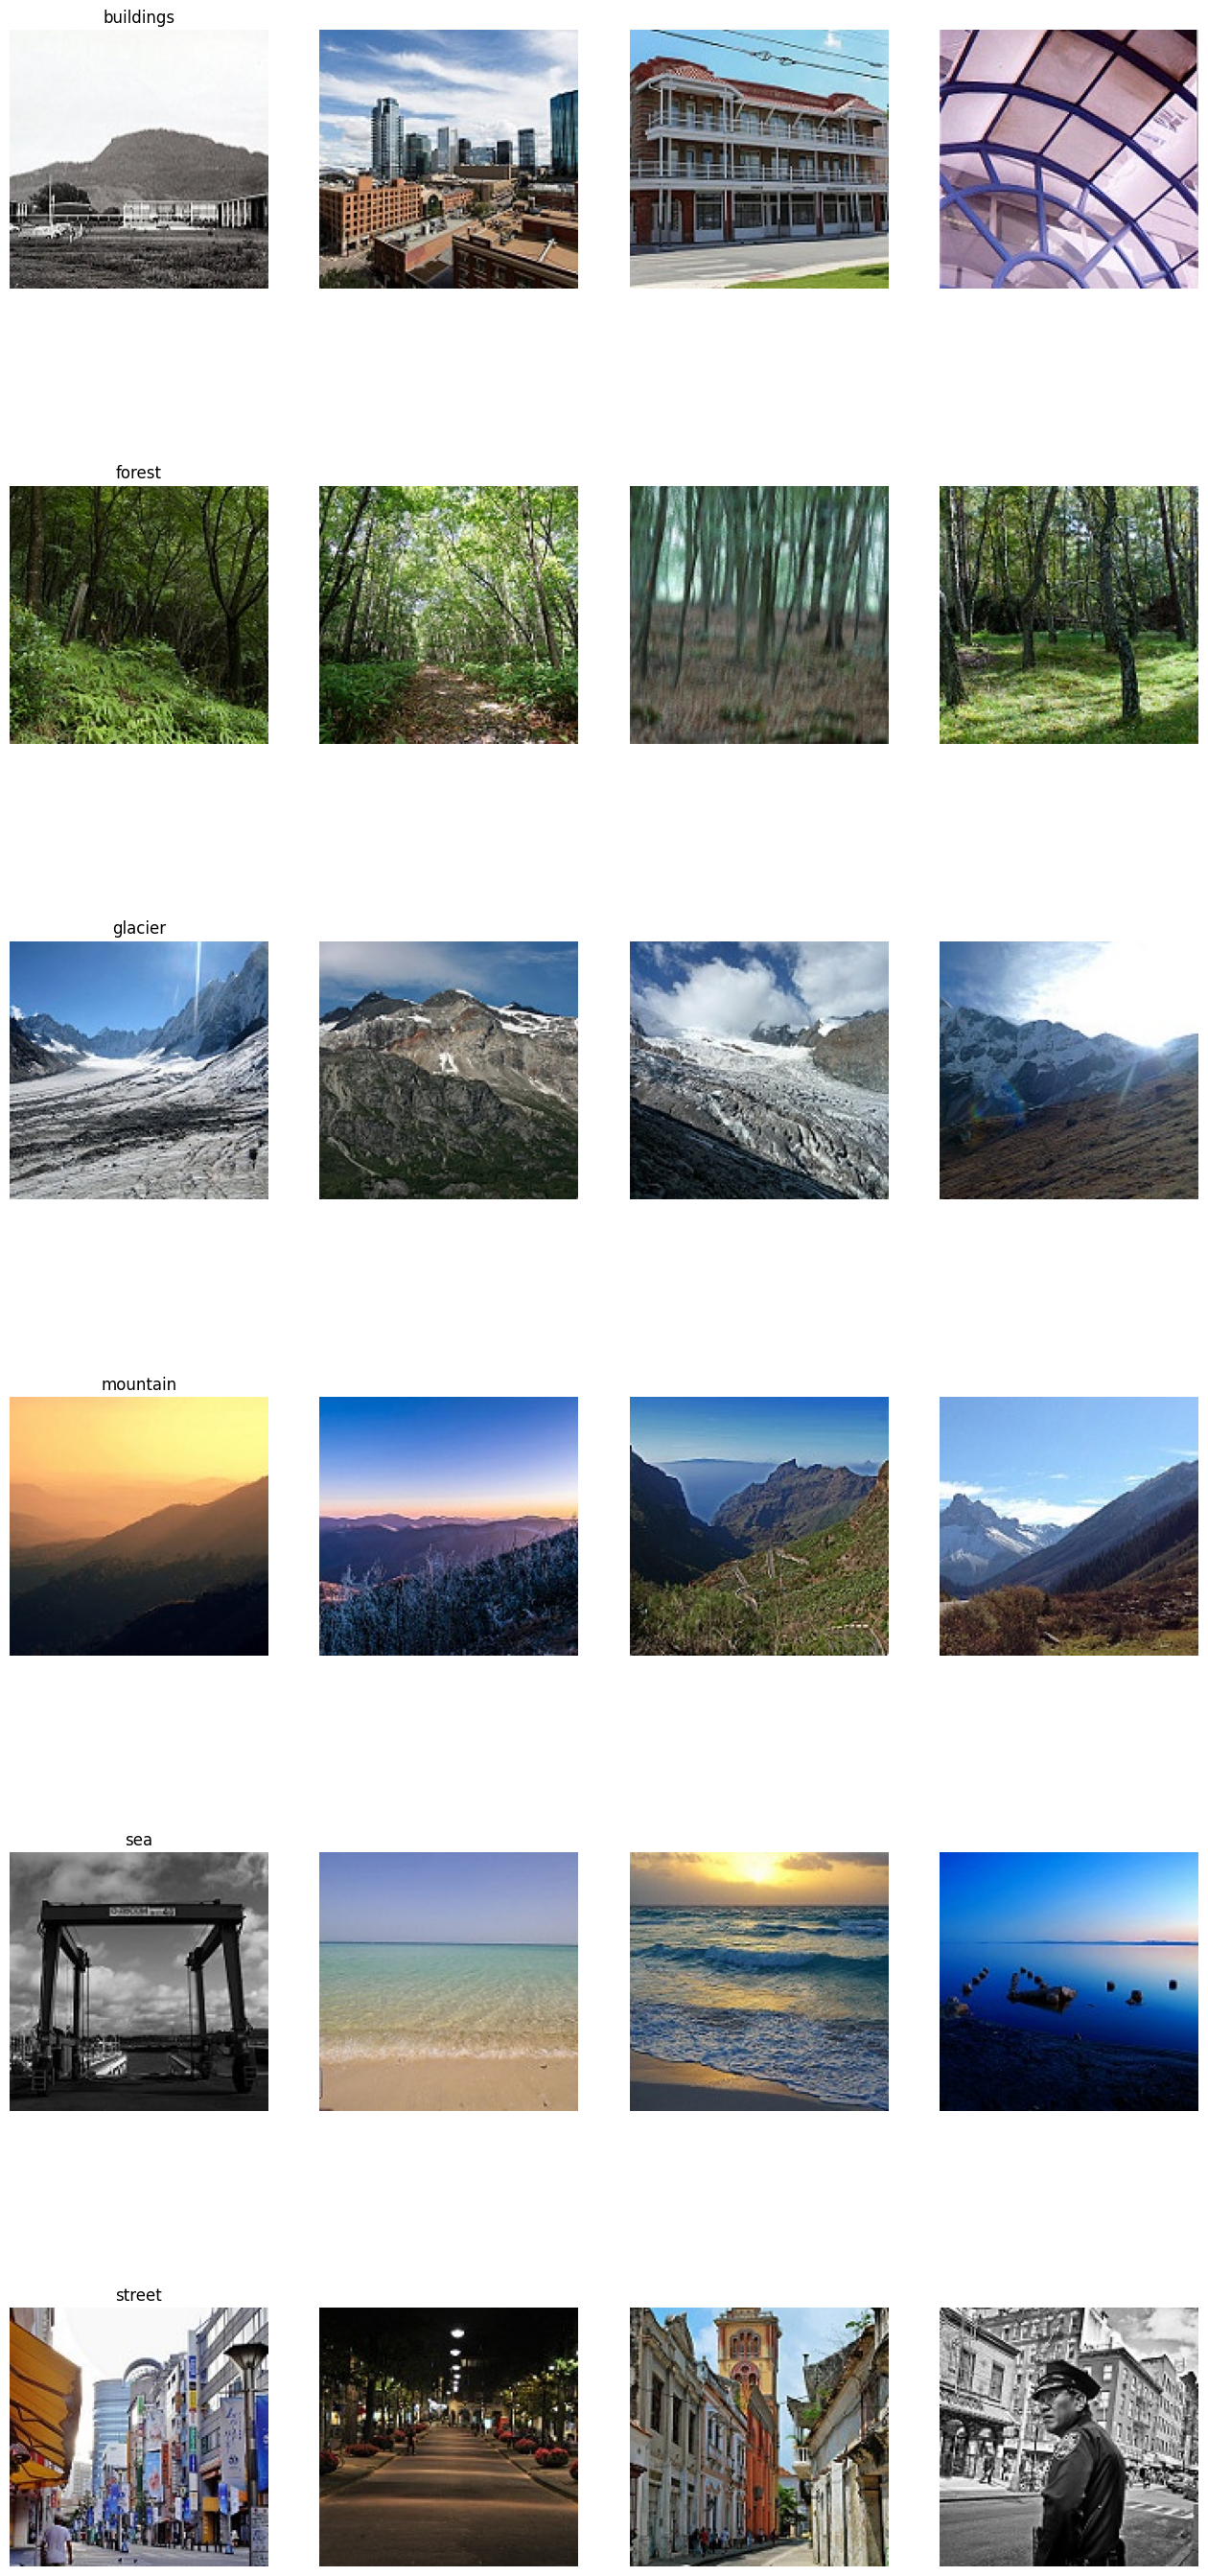

In [5]:
base_dir = r'C:\Users\rafid\OneDrive\Desktop\VSCode\Python\Image Classification\Datasets\Intel Image Classification\seg_train\seg_train'

rows = 6
cols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 6)

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

all_images = []
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    image_paths = [os.path.join(class_path, fname) for fname in os.listdir(class_path)
                   if fname.lower().endswith(valid_extensions)][pic_index:pic_index + 4]
   
    all_images.extend(image_paths)
                       

for i, img_path in enumerate(all_images):
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

  if i % 4 == 0:
      sp.title.set_text(classes[i // 4])

  
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.1)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_train/seg_train/',
    subset = 'training',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'sparse',
    seed = 1,
    color_mode = 'rgb',
    shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_train/seg_train/',
    subset = 'validation',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'sparse',
    seed = 1,
    color_mode = 'rgb',
    shuffle=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_test/seg_test/',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'sparse',
    seed = 1,
    color_mode = 'rgb',
    shuffle = False)

x_batch, y_batch = next(train_generator)
print("Labels for first batch: ", y_batch[:5]) 

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Labels for first batch:  [4. 0. 4. 4. 5.]


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(6, activation='softmax'))

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=20, min_lr= 0.00001, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=20, restore_best_weights=True, verbose=2)

callbacks_list = [rlrop, early_stop]

model.compile(optimizer=Adam(learning_rate=ADAM_LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 batch_normalization_10 (Bat  (None, 148, 148, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_11 (Bat  (None, 72, 72, 32)       128       
 chNormalization)                                                
                                                      

In [19]:
history = model.fit(
    x = train_generator,
    validation_data = validation_generator,
    shuffle = True,
    epochs = EPOCHS,
    steps_per_epoch = 12632//BS,
    validation_steps =  1402//BS,
    callbacks = callbacks_list,
)

Epoch 1/100
197/197 [==============================] - 286s 1s/step - loss: 1.4380 - accuracy: 0.4270 - val_loss: 2.3865 - val_accuracy: 0.1882 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 72s 366ms/step - loss: 1.0537 - accuracy: 0.5878 - val_loss: 1.8319 - val_accuracy: 0.3237 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 72s 366ms/step - loss: 0.8789 - accuracy: 0.6845 - val_loss: 1.4195 - val_accuracy: 0.4539 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 80s 406ms/step - loss: 0.8130 - accuracy: 0.7223 - val_loss: 1.3520 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 73s 371ms/step - loss: 0.7451 - accuracy: 0.7544 - val_loss: 0.9767 - val_accuracy: 0.6682 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 73s 371ms/step - loss: 0.7050 - accuracy: 0.7730 - val_loss: 1.3114 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 7/100
197/197 [===========================

Classifier
────────────────────────────────────────────────────────────
Train Accuracy:  0.920
Train Loss:  0.265
Validation Accuracy:  0.825
Validation Loss:  0.493
Test Accuracy: 0.832
Test Loss: 0.481
────────────────────────────────────────────────────────────
Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.69      0.79       437
      forest       0.94      0.98      0.96       474
     glacier       0.92      0.64      0.76       553
    mountain       0.72      0.88      0.79       525
         sea       0.80      0.91      0.85       510
      street       0.79      0.90      0.84       501

    accuracy                           0.83      3000
   macro avg       0.85      0.83      0.83      3000
weighted avg       0.85      0.83      0.83      3000



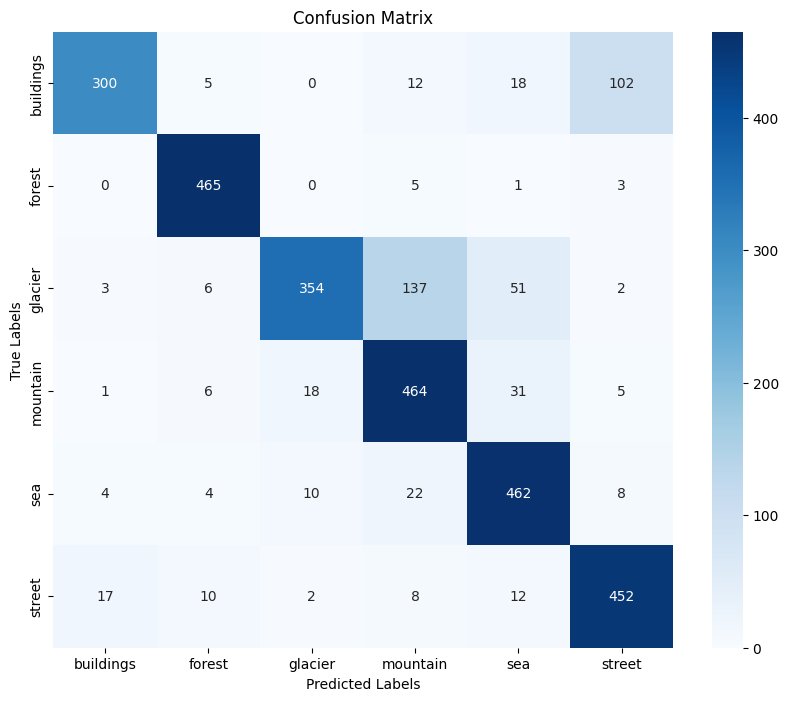

────────────────────────────────────────────────────────────
Accuracy Score (Manual Check): 0.832


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

best_accuracy_index = np.argmax(history.history['accuracy'])
best_train_accuracy = max(history.history['accuracy'])
best_train_loss = history.history['loss'][best_accuracy_index]

validation_loss, validation_accuracy = model.evaluate(validation_generator, verbose=0)

predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = test_generator.classes               
class_labels = list(test_generator.class_indices.keys())  

print("Classifier")
print("─" * 60)
print('Train Accuracy: ', "{:.3f}".format(best_train_accuracy))
print('Train Loss: ', "{:.3f}".format(best_train_loss))
print('Validation Accuracy: ', "{:.3f}".format(validation_accuracy))
print('Validation Loss: ', "{:.3f}".format(validation_loss))
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}")
print("─" * 60)

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("─" * 60)
print("Accuracy Score (Manual Check): {:.3f}".format(accuracy_score(true_classes, predicted_classes)))


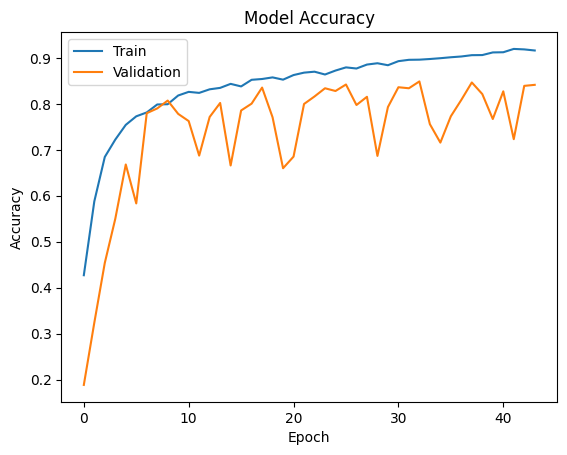

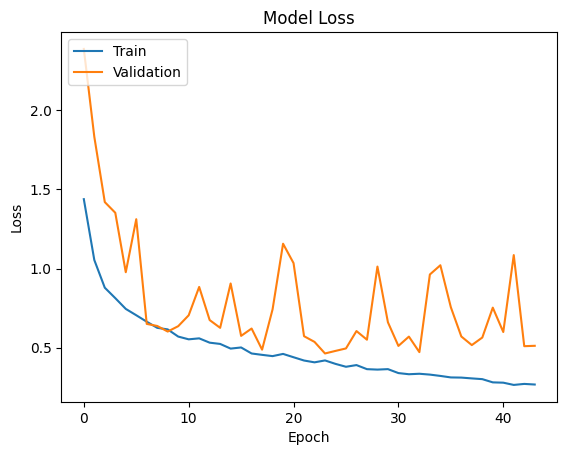

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % Test_results[1]
model.save('/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Saved Models/' + 'Keras-CNN' + epoch_str + test_acc + '.h5')